In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [74]:
Nx = 10; Ny = 15; N=Nx*Ny; p = 1; q = Ny; cut_off = Nx;
PN = [0,1,2];
U = 2;
print("Magnetic flux per unit-cell:",p/q,"\n Number of flux quanta:",Nx)

Magnetic flux per unit-cell:0.06666666666666667
 Number of flux quanta:10

# Single-Particle

In [75]:
@doc get_sp_op

Compute the single-particle operator from single-particle matrix.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `N::Integer`: The total site number.
  * `sp_matrix::Matrix`: Hopping phases matrix from any model.


In [76]:
sp_basis = NLevelBasis(N)
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [77]:
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [78]:
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix) # true
#show(stdout, "text/plain", eigvals(sp_matrix))

true

In [79]:
@doc get_sub_states

Compute the first eigen-states in a given number.

#### Arguments

  * `sp_op::get_sp_op`: Single-particle operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [80]:
sub_states = get_sub_states(H1, cut_off);

In [81]:
@doc get_projector_op

Compute sub-space basis, projection and comlex conjugate of projection operator.

#### Arguments

  * `states::get_sub_states`: Eigen-states of the sub-space.
  * `basis::NLevelBasis`: Single-particle basis.


In [82]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [83]:
@doc get_subspace_op

Compute the corresponding operator in the sub-space.

#### Arguments

  * `sp_op::Operator`: Single-particle operator from single-particle matrix.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [84]:
H1_sub = get_subspace_op(H1, P, Pt);

In [85]:
@doc get_num_sub_list

Compute the single-particle number operator for each lattice sites.

#### Arguments

  * `N::Integer`: The total site number.
  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [86]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many-Body

In [87]:
@doc get_mb_op

Compute the many-body operator for boson particles from single-particle operator.

#### Arguments

  * `basis_mb`: Many-body basis.
  * `basis_sub::get_projector_op[1]`: Sub-space basis.
  * `sp_op::Operator`: Single-particle operator from single-particle matrix.


In [88]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [89]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [90]:
# states_mb = bosonstates(b_sub, PN) 
# basis_mb = ManyBodyBasis(b_sub, states_mb)

In [91]:
# H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [92]:
# @doc get_num_mb_list

In [93]:
# num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

In [94]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

In [95]:
@doc Hubbard_Interaction

Compute the on-site Bose-Hubbard Interaction term.

#### Arguments:

  * `basis_cut_sp`: The cutt-off sites of bosonic many-body basis.
  * `basis_cut_mb`: The cutt-off sites of single-particle basis.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of projection operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [96]:
#bcut_mb, bcut = get_Bosonic_MB_Basis(cut_off,PN)
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Constructing Total Hamiltonians 

In [97]:
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end

H_total_imp = get_total_H(4, 45, number_mb_list_operators, H1cut, H_Int)
H_total = get_total_H(0, 45, number_mb_list_operators, H1cut, H_Int);

# Exact-Diagonalization

In [137]:
using DataFrames

E, V = eigenstates(dense((H_total_imp+dagger(H_total_imp))/2))
E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [138]:
PN

3-element Vector{Int64}:
 0
 1
 2

In [139]:
pn = 2.0
df = get_energies(pn, E, V, basis_cut_mb)
df_0 = get_energies(pn, E0, V0, basis_cut_mb)
filtered_energies = Matrix(df)[:,2]
filtered_energies_0 = Matrix(df_0)[:,2]
show(stdout,"text/plain", filtered_energies_0) #show all outputs

55-element Vector{Float64}:
 -7.2054302883637
 -7.205430288363695
 -7.205430288363691
 -7.2054302883636785
 -7.2054302883636785
 -7.205430151875442
 -7.205430151875436
 -7.205430151875429
 -7.2054301518754205
 -7.205430151875413
 -7.205429956573522
 -7.2054299565735205
 -7.205429956573519
 -7.205429956573516
 -7.2054299565735125
 -7.205420817368616
 -7.205420817368611
 -7.20542081736861
 -7.205420817368608
 -7.205420817368604
 -7.205420317737425
 -7.205420317737422
 -7.20542031773742
 -7.205420317737416
 -7.205420317737409
 -7.205408460212909
 -7.205408460212907
 -7.205408460212904
 -7.205408460212897
 -7.205408460212893
 -7.205407612515222
 -7.205407612515221
 -7.205407612515219
 -7.2054076125152156
 -7.205407612515215
 -7.139712569219476
 -7.139712569219469
 -7.139712569219466
 -7.13971256921946
 -7.139712569219458
 -7.139698569352079
 -7.139698569352072
 -7.139698569352069
 -7.1396985693520625
 -7.13969856935206
 -7.137861157558868
 -7.1378611575588655
 -7.137861157558865
 -7.137861

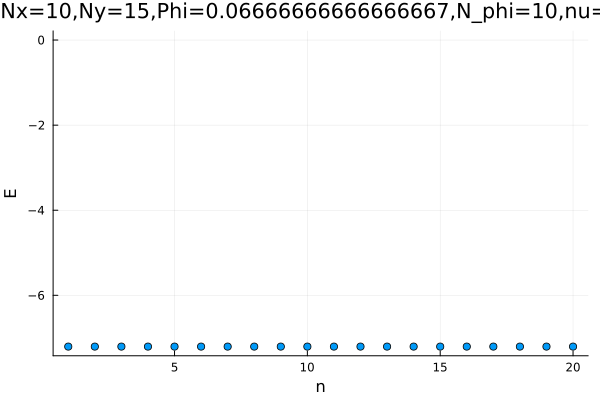

In [140]:
using Plots
plot(1:20,E,seriestype=:scatter,xlabel="n",ylabel="E",legend=false)
title!("Nx=$(Nx),Ny=$(Ny),Phi=$(p/q),N_phi=$(Nx),nu=$(pn/Nx)")
#ylims!((-10.50,-10.0))

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [141]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [142]:
r_hubbard_states = Restricted_Hubbard_States(V);
r_hubbard_states_0 = Restricted_Hubbard_States(V0);

# Density Profile

In [143]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = basis_cut_mb
index_number_op = 4
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
expect(Op, r_hubbard_states[index_eigen_states])
expect(Op, r_hubbard_states_0[index_eigen_states])

#or
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.03196171877833969 - 5.480303168735323e-19im

In [144]:
function get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states)
    Sum = 0
    total_expect_list=[]
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)
        n_i = 0
        for index_eig_states in 1:q        
            Sum += expect(Op, r_hubbard_states[index_eig_states])
            n_i += expect(Op, r_hubbard_states[index_eig_states])
        end
        push!(total_expect_list, n_i)
    end
    return real(total_expect_list)
end
get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states)

150-element Vector{Float64}:
 0.20842074619661696
 0.21214956997296883
 0.21380617558181678
 0.2124915649766127
 0.21126910522437503
 0.2124915649833013
 0.2138061755946237
 0.21214956998609394
 0.20842074620764808
 0.20640905604751514
 0.23468963551520255
 0.23185935385384204
 0.22020479897239414
 ⋮
 0.1943334399139232
 0.19234601370711565
 0.1951281263910048
 0.20051912000810276
 0.20645770038768133
 0.21059039834346138
 0.2118759906721402
 0.21059039837207677
 0.20645770042239908
 0.20051912001831618
 0.1951281263872809
 0.19276792501384715

In [145]:
index_eig_states = 1
function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list=[]
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)      
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list,expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end
get_density_profiles(NM_MB_Array_Storage,r_hubbard_states, index_eig_states)

150-element Vector{Float64}:
 0.034686158678596715
 0.035169759456704495
 0.03500788663096554
 0.03425398055272781
 0.03385386794584056
 0.03425397948844365
 0.03500788404983797
 0.0351697586672556
 0.03468615781114394
 0.03439409830651254
 0.021892023714498318
 0.023080464694648004
 0.022872534873390818
 ⋮
 0.008995179500065908
 0.009015344378547292
 0.023866725853239026
 0.023916678445203544
 0.023866754476273982
 0.023726213559222137
 0.02366979970531109
 0.02372621248350787
 0.02386675221657589
 0.023916679468891047
 0.02386672631906873
 0.023850450361485538

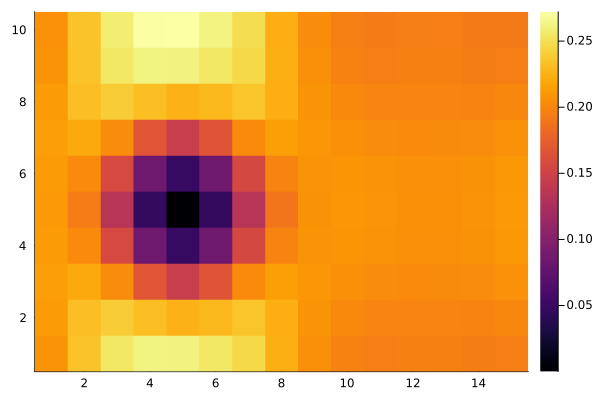

In [158]:
heatmap(reshape(get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states), Nx, Ny),interpolate=true)

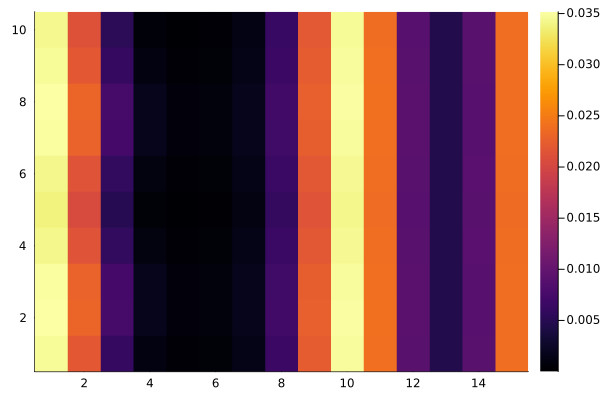

In [147]:
heatmap(reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states), Nx, Ny))

In [132]:
using Interpolations

function Interp2D(data, factor)
    
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)

    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)

    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end

    return finerx, finery, data_interp

end  

Interp2D (generic function with 1 method)

In [194]:
using CairoMakie


function mandelbrot(x, y)
    z = c = x + y*im
    for i in 1:30.0; abs(z) > 2 && return i; z = z^2 + c; end; 0
end

heatmap(-2:0.1:1, -1.1:0.1:1.1, mandelbrot,
    colormap = Reverse(:deep))

LoadError: MethodError: no method matching plot_color(::Reverse{Symbol})

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

[0mClosest candidates are:
[0m  plot_color(::Any, [91m::Number[39m) at C:\Users\Can\.julia\packages\PlotUtils\bZEEj\src\colors.jl:24
[0m  plot_color(::Any, [91m::Nothing[39m) at C:\Users\Can\.julia\packages\PlotUtils\bZEEj\src\colors.jl:21
[0m  plot_color([91m::Colorant[39m) at C:\Users\Can\.julia\packages\PlotUtils\bZEEj\src\colors.jl:16
[0m  ...

In [218]:
data[1,5]

0.8711340049481474

In [219]:
data1[1,7]

0.24657345771744874

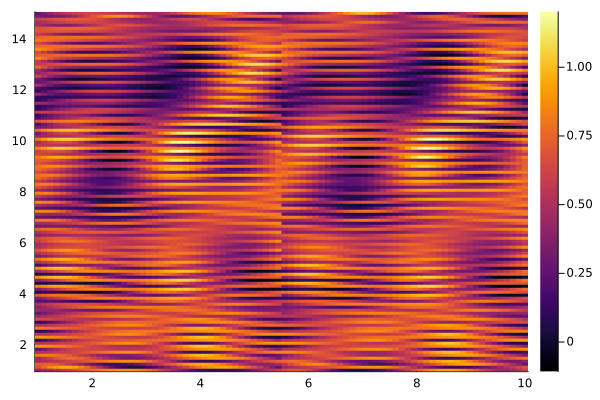

In [228]:
# Test
data = rand(10,15)

# Simple heatmap
heatmap(data)      

# Heatmap of Interpolated data            
heatmap(Interp2D(data, 8))   

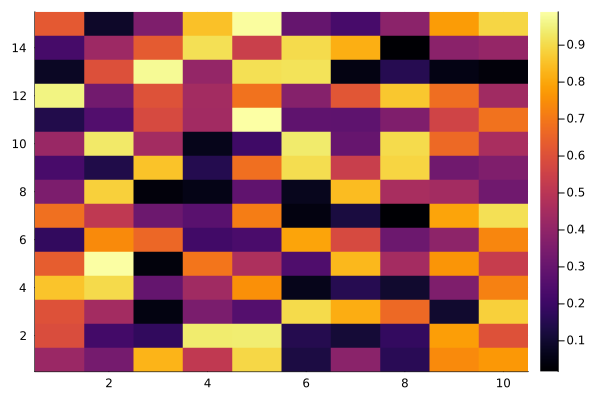

In [226]:
heatmap(Interp2D(data, 1))

$\mathcal{Q}_\rho = \sum_i \left( <n_i>_{V\neq0} - <n_i>_{V=0} \right)$

In [122]:
Q_rho = sum()

LoadError: MethodError: no method matching sum()

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

[0mClosest candidates are:
[0m  sum([91m::Union{Function, Type}[39m, [91m::StaticArraysCore.StaticArray{<:Tuple, T}[39m; dims) where T at C:\Users\Can\.julia\packages\StaticArrays\pTgFe\src\mapreduce.jl:286
[0m  sum([91m::SciMLBase.AbstractDiffEqLinearOperator[39m; kwargs...) at C:\Users\Can\.julia\packages\SciMLBase\zXEYU\src\operators\common_defaults.jl:72
[0m  sum([91m::DataStructures.Accumulator[39m) at C:\Users\Can\.julia\packages\DataStructures\59MD0\src\accumulator.jl:62
[0m  ...

# Animation

In [39]:
# animated_exp_list = zeros(N,1,length(r_hubbard_states))
# function animated_e_l()
#     for i in 1:length(r_hubbard_states)
#         expect_list=[]
#         for j in 1:N
#             T = NM_MB_Array_Storage[:,:,j]
#             Op = Operator(BL,BR,T)
#             push!(expect_list,expect(Op, r_hubbard_states[i]))
#         end
#         animated_exp_list[:,:,i] = real(expect_list)
#     end
#     return animated_exp_list
# end

In [40]:
# k = 1
# initial_condition = reshape(animated_e_l()[:,:,k], Nx, Ny) #psi_1 (psi_k)'e karşılık gelen density matrix
# heatmap(initial_condition)

In [41]:
# initial_condition = reshape(animated_e_l()[:,:,1], Nx, Ny)
# fps = 20
# function heatgif(initial_condition)
#     p = heatmap(initial_condition, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U, fps=$fps"))
#     anim = @animate for i=1:length(r_hubbard_states)
#         h_map_matrix = reshape(animated_e_l()[:,:,i],Nx,Ny)
#         heatmap!(p[1], h_map_matrix)
#     end
#     return anim
# end

In [42]:
# anim = heatgif(initial_condition)
# gif(anim, "OUTPUT.gif", fps=fps)